In [2]:
import numpy as np
import sep

In [3]:
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10.,8.]

In [4]:
image_name = 'hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits'

with fits.open(image_name) as hdul:
    data = hdul[0].data.astype(np.float64) 

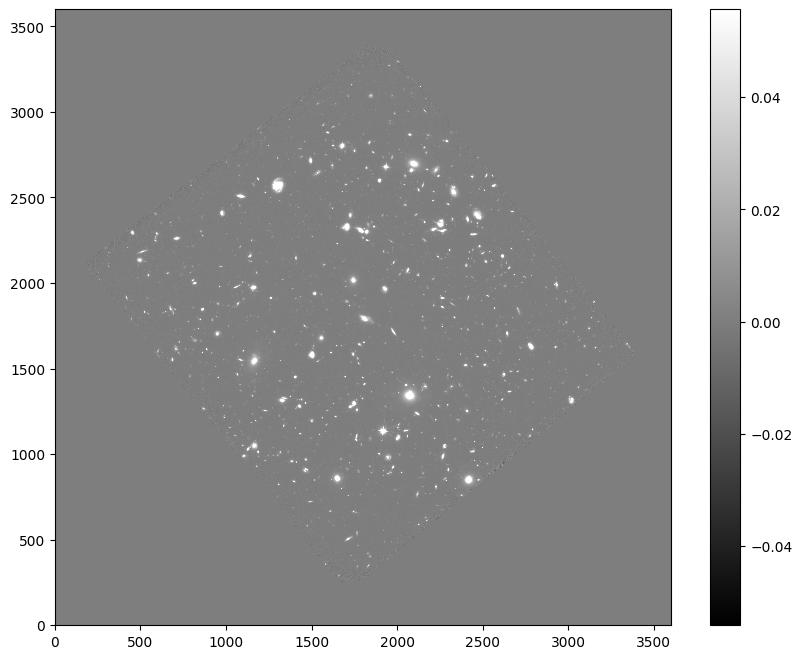

In [5]:
m, s =np.mean(data), np.std(data)
plt.imshow(data,interpolation='nearest',cmap='gray', vmin=m-s,vmax=m+s, origin='lower')
plt.colorbar();

In [6]:
bkg = sep.Background(data)
print(bkg.globalback)
print(bkg.globalrms)


0.0
0.0005398219218477607


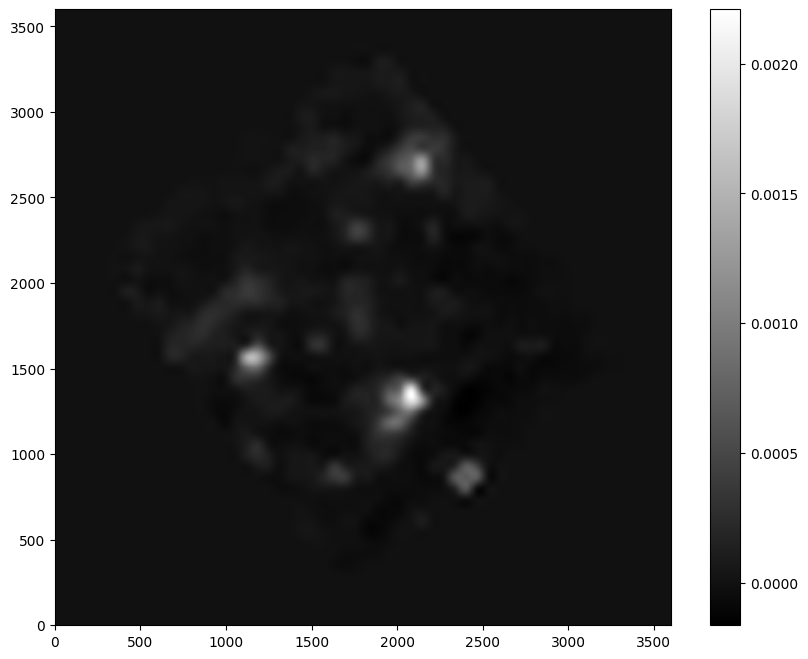

In [7]:
bkg_image = bkg.back()
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

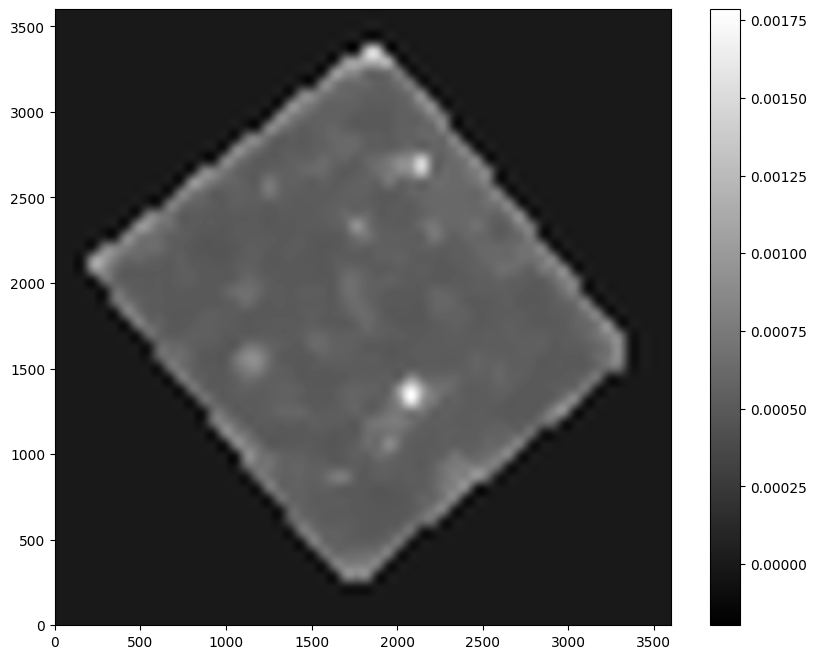

In [8]:
bkg_rms = bkg.rms()
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [10]:
data_sub = data - bkg
objects = sep.extract(data_sub, 5, err=bkg.globalrms)

In [11]:
len(objects)

2634

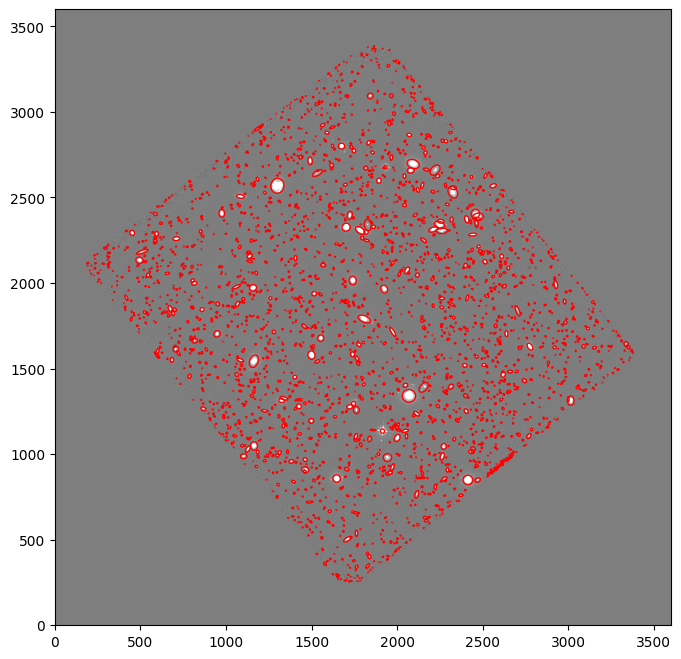

In [12]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=5*objects['a'][i],
                height=5*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [13]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     1.0, err=bkg.globalrms, gain=1.0)

for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.013949 +/- 0.118109
object 1: flux = 0.014969 +/- 0.122350
object 2: flux = 0.012178 +/- 0.110359
object 3: flux = 0.019764 +/- 0.140589
object 4: flux = 0.011700 +/- 0.108172
object 5: flux = 0.021315 +/- 0.145999
object 6: flux = 0.016670 +/- 0.129115
object 7: flux = 0.014053 +/- 0.118551
object 8: flux = 0.012657 +/- 0.112507
object 9: flux = 0.014891 +/- 0.122031


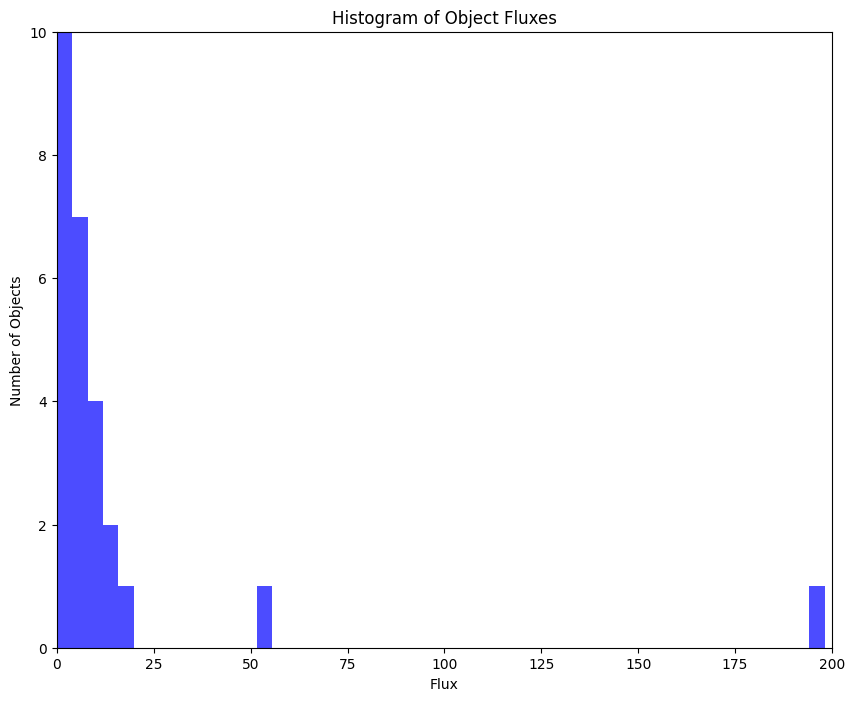

In [16]:
plt.figure()
plt.hist(flux, bins=50, range=(np.min(flux), np.max(flux)), color='blue', alpha=0.7)
bin_width = 0.1
plt.ylim(0, 10)
plt.xlim(0, 200)
plt.xlabel("Flux")
plt.ylabel("Number of Objects")
plt.title("Histogram of Object Fluxes")
plt.show()

In [17]:
np.mean(flux)

0.2256257363831055

In [18]:
np.median(flux)

0.028285559816285978

In [19]:
std_dev = np.std(flux)

print(std_dev)

4.060570412099396


In [20]:
numbers = flux
largest = max(numbers)
print(largest)

198.10137405395517


In [22]:
def calculate_zscore(data, value):
  mean = np.mean(flux)
  std_dev = np.std(flux)
  z_score = (value - mean) / std_dev
  return z_score

outlier = 198.10137405395517

z_score = calculate_zscore(flux, outlier)

print("The outlier is", z_score, "standard deviations away from the mean")

The outlier is 48.731022549924546 standard deviations away from the mean


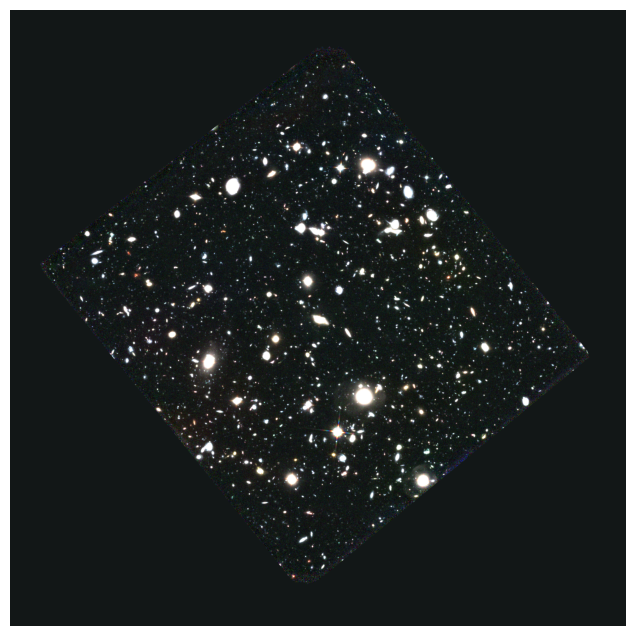

In [40]:
f160w_file = "hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"
f125w_file = "hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
f105w_file = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"

def normalize(image):
    vmin = np.percentile(image, 1) 
    vmax = np.percentile(image, 99)  
    image = np.clip((image - vmin) / (vmax - vmin), 0, 1)  
    return image
    
with fits.open(f160w_file) as hdu1, fits.open(f125w_file) as hdu2, fits.open(f105w_file) as hdu3:
    f160w_data = hdu1[0].data.astype(np.float64) 
    f125w_data = hdu2[0].data.astype(np.float64) 
    f105w_data = hdu3[0].data.astype(np.float64) 

r = normalize(f160w_data)
g = normalize(f125w_data)
b = normalize(f105w_data)
     
rgb_image = np.dstack((r, g, b))

plt.imshow(rgb_image, origin="lower")
plt.axis("off")
plt.savefig("rgb_image.png", dpi=300, bbox_inches='tight')
plt.show()